# Test Notebook
Load a trained model to show the performance.

In [17]:
from model.phinet_v3 import PhiNetV3
import torch
import torch.nn as nn
from micromind import PhiNet

import torchvision
import torchvision.transforms as transforms

# Avalanche modules
from avalanche.benchmarks.classic import SplitCIFAR10

import utility.utils as utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

def test(dataset, model, criterion, device, eval_mb_size):       
        sum_accuracy = 0
        exps_acc = dict()
        results = [[],[]]
        for exp in dataset:
            print("Testing task ", exp.task_label)
            print('Classes in this task:', exp.classes_in_this_experience)

            experience_dataloader = DataLoader(exp.dataset, batch_size=eval_mb_size, shuffle=False)
            test_acc, test_loss = utils.test(model, criterion, experience_dataloader, device)
            sum_accuracy += test_acc
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
            exps_acc[exp.task_label] = test_acc

            results[0].append(f"Task {exp.task_label}")
            results[1].append(test_acc)

        # Calculate and add average accuracy
        avg_accuracy = sum_accuracy / len(dataset)
        results[0].append(f"Avg Acc")
        results[1].append(avg_accuracy)

        print(f"Average accuracy: {avg_accuracy:.2f}%")

# Define a function to visualize predictions for a specific task
def visualize_predictions_for_task(model, dataset, device, num_images=5):
    data_loader = DataLoader(
            dataset,
            batch_size=16,
            shuffle=True,
        )
    classes = dataset.targets
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    count = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets, _ = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(targets)):
                image = np.transpose(inputs[i].cpu().numpy(), (1, 2, 0))
                true_label = classes[targets[i]]

                predicted_label = classes[predicted[i]]

                plt.imshow(image)
                plt.title(f'True: {true_label}, Predicted: {predicted_label}')
                plt.show()

                count += 1
                if count >= num_images:
                    return


Files already downloaded and verified
Files already downloaded and verified
Device: cuda
Testing task  0
Classes in this task: [1, 4]


/home/tremonti/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Loss: 0.3571, Test Accuracy: 88.95%
Testing task  1
Classes in this task: [5, 7]
Test Loss: 0.4428, Test Accuracy: 85.90%
Testing task  2
Classes in this task: [9, 3]
Test Loss: 0.4138, Test Accuracy: 85.95%
Testing task  3
Classes in this task: [8, 0]
Test Loss: 0.2603, Test Accuracy: 91.45%
Testing task  4
Classes in this task: [2, 6]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Loss: 0.3704, Test Accuracy: 87.25%
Average accuracy: 87.90%


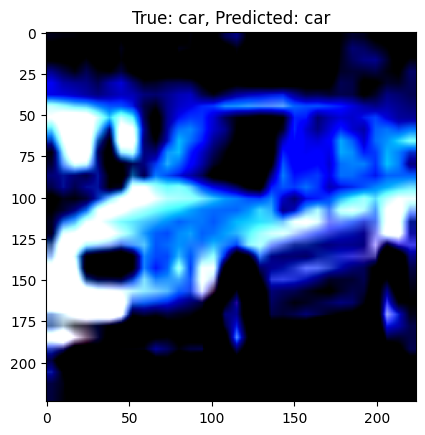

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


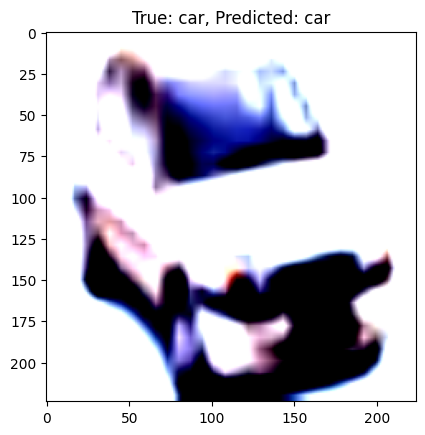

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


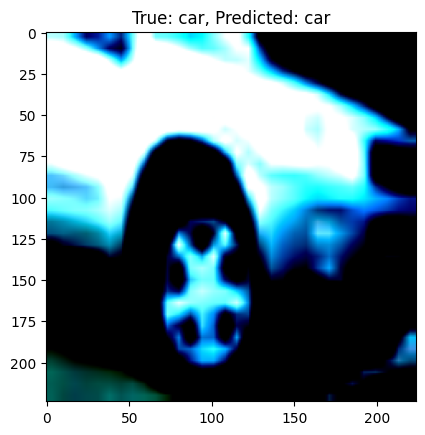

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


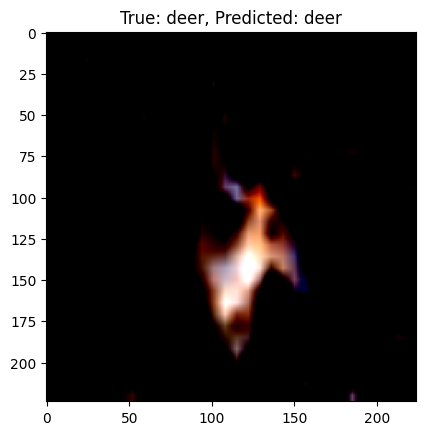

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


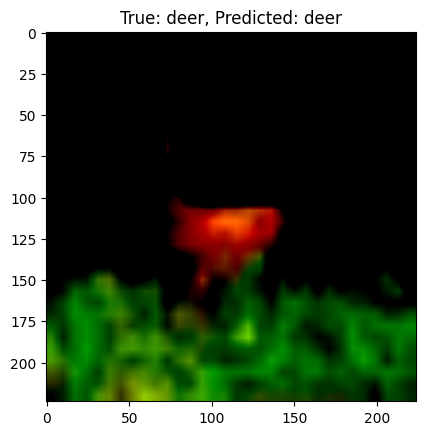

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


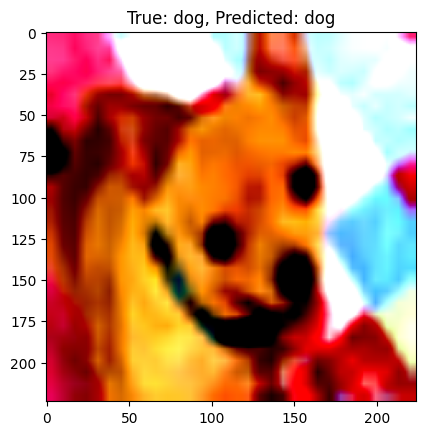

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


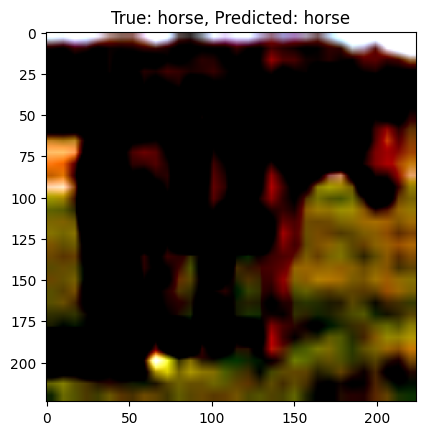

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


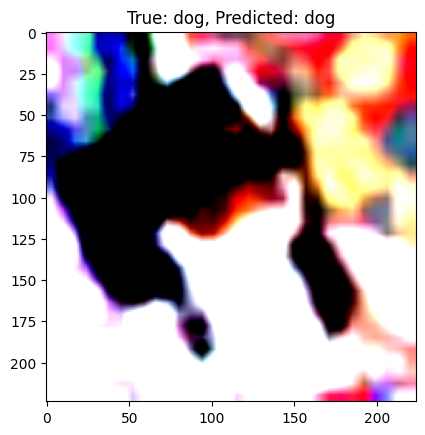

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


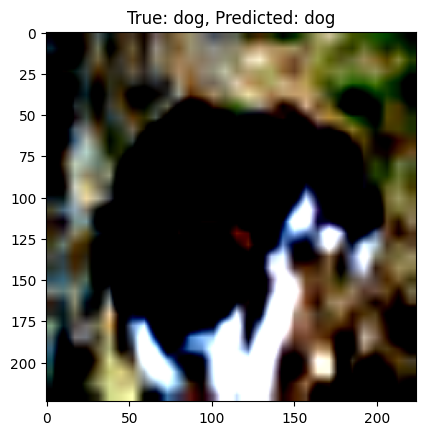

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


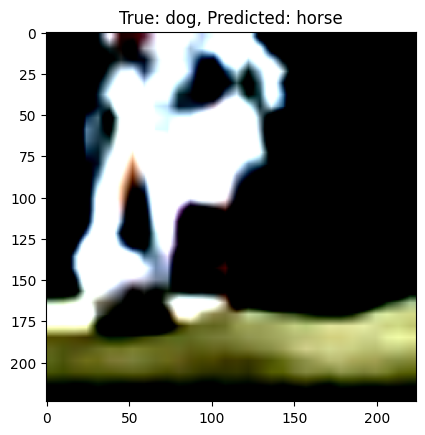

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


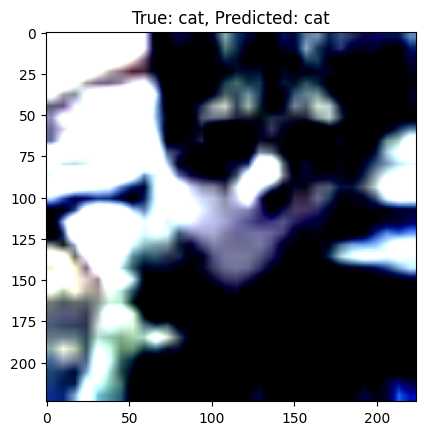

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


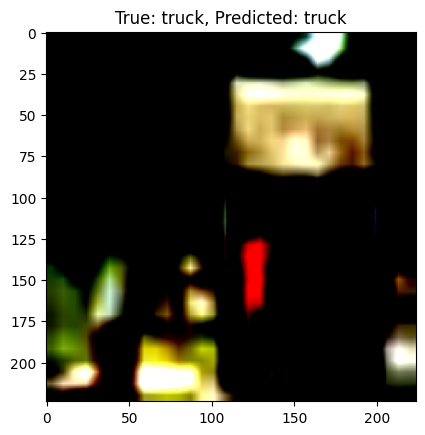

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


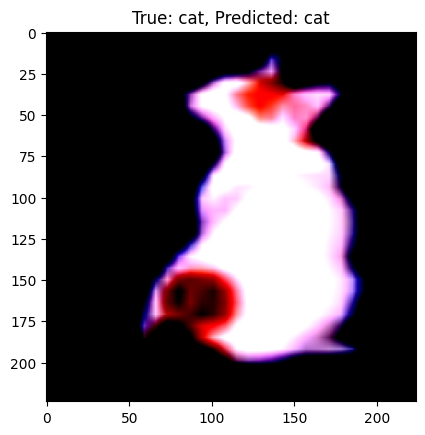

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


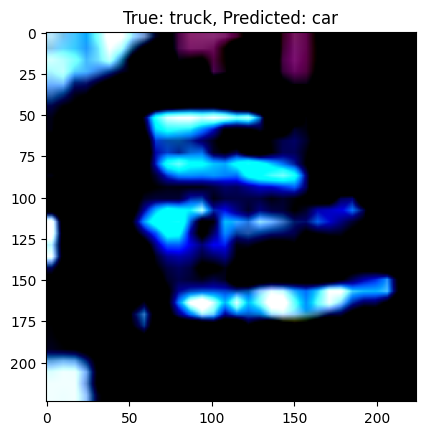

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


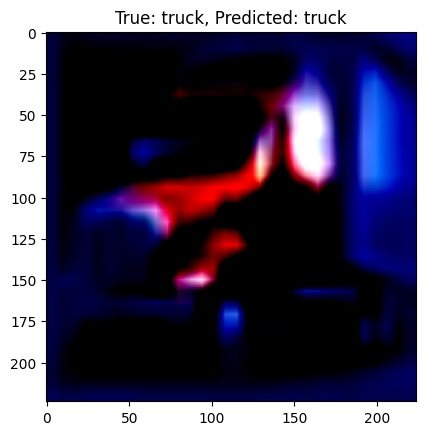

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


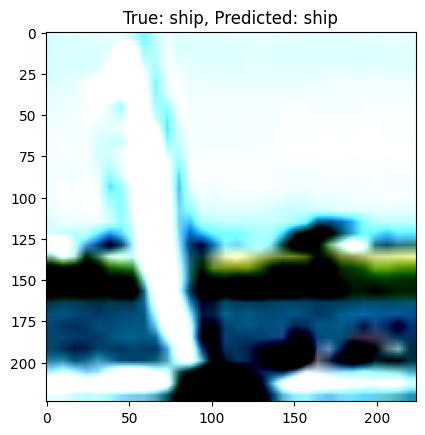

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


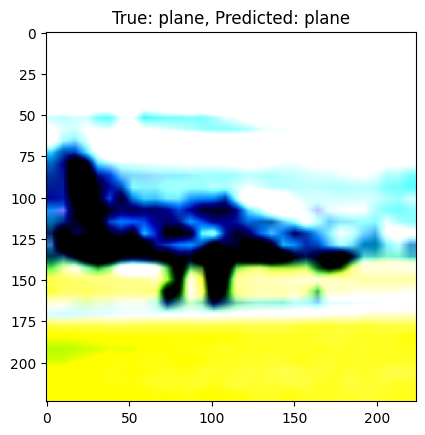

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


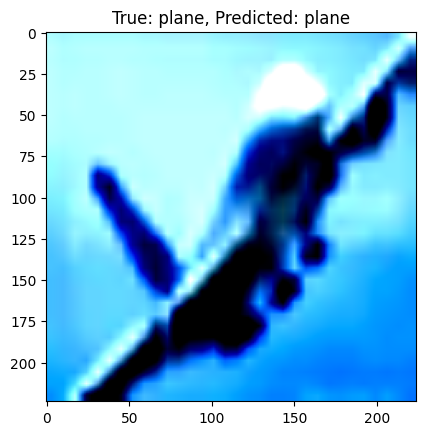

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


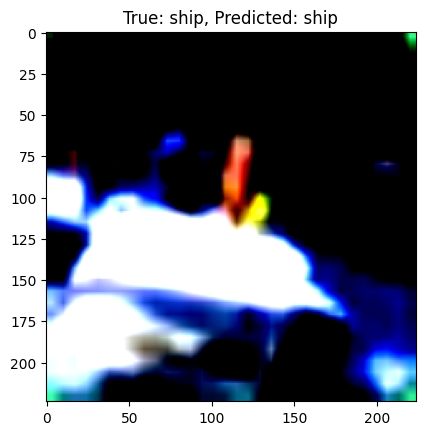

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


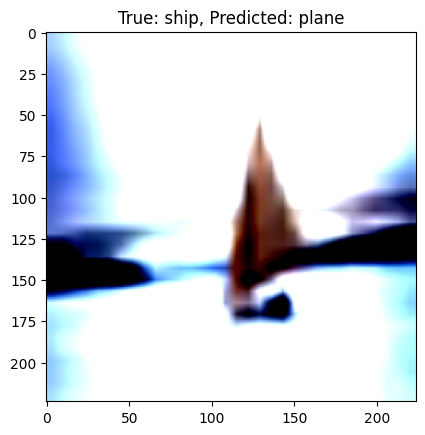

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


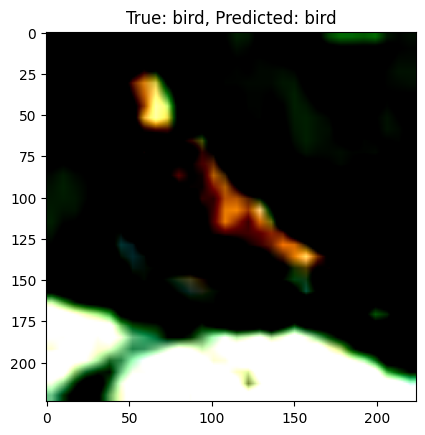

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


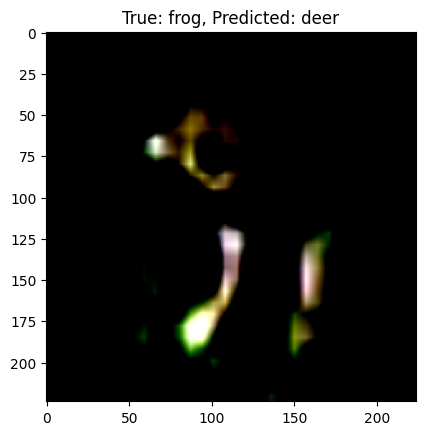

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


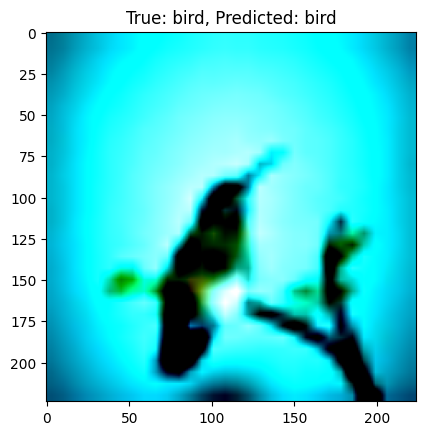

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


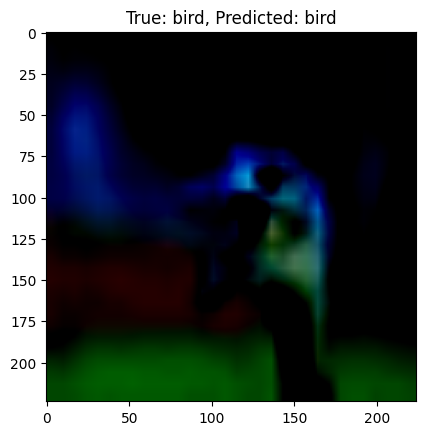

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


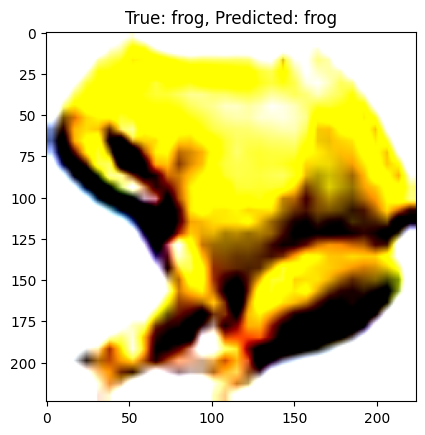

In [18]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

split_cifar = SplitCIFAR10(n_experiences=5, seed=0, return_task_id = True, train_transform = transform, eval_transform = transform)

# recovering the train and test streams
train_stream = split_cifar.train_stream
test_stream = split_cifar.test_stream

torch.manual_seed(0)
# Loss criterion
criterion = nn.CrossEntropyLoss()

input_shape = (3, 224, 224)
torch.cuda.set_device(2) if torch.cuda.is_available() else None

# Set the device as cuda, the GPU specified as default will be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Device: {device}")    

phinet = PhiNet(input_shape = input_shape, alpha = 3, beta = 0.75, t_zero = 6, num_layers=7 ,include_top = False, num_classes = 1000).to(device)

model = PhiNetV3(phinet, latent_layer_num = 10).to(device)

# Load the saved state dictionary
saved_state_dict = torch.load("./results/latent_10/weight_decay_0/lr_5e-05_epochs_10_rm_MB_325_rm_None_split_0.8.pth", map_location=torch.device(device))  # Replace with the actual path

# Load the state dictionary into the model
model.load_state_dict(saved_state_dict)

test(test_stream, model, criterion, device, eval_mb_size=16)

model.eval()  # Set the model to evaluation mode

for exp in test_stream:
    visualize_predictions_for_task(model, exp.dataset, device, num_images=5)